In [656]:
# General Libraries
import numpy as np
import pandas as pd

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# Visualization Libraries
import matplotlib.pyplot as plt

# **Load and Explore Dataset**

In [657]:
# Load Dataset
data = pd.read_csv("UNSW_NB15_training-set.csv")

# Preview Dataset
data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0


In [658]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [659]:
# Check for missing values
print(data.isnull().sum())

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

# **Data Preprocessing**

In [660]:
# Removing unnecessary columns
data.drop(['id','attack_cat'],axis=1,inplace=True)

In [661]:
# Clamp extreme values (outliers) in numeric columns
for col in data.select_dtypes(include='number').columns:  # Loop through numeric columns
    max_value = data[col].max()
    median_value = data[col].median()
    
    # If the max value is unusually large (more than 10x the median and >10), cap it at the 95th percentile
    if max_value > 10 * median_value and max_value > 10:
        threshold = data[col].quantile(0.95)  # 95th percentile
        data[col] = np.minimum(data[col], threshold)  # Cap values above the threshold


In [662]:
# Log-transform numeric columns with many unique values to handle skewness
for col in data.select_dtypes(include='number').columns:
    # Apply log1p if there are more than 50 unique values and the column has a minimum value of 0 or greater
    if data[col].nunique() > 50:
        data[col] = np.log1p(data[col])  # Use log1p to handle zero or positive values

# Simplify high-cardinality categorical columns
for col in data.select_dtypes(exclude='number').columns:
    # If the column has more than 6 unique values, group less frequent ones into a placeholder '-'
    if data[col].nunique() > 6:
        top_categories = data[col].value_counts().head().index  # Get the top 5 most common categories
        data[col] = np.where(data[col].isin(top_categories), data[col], '-')  # Replace rare values with '-'


In [663]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.000011,udp,-,INT,1.098612,0.000000,6.208590,0.000000,11.417626,254,0,19.010486,0.000000,0.0,0.0,0.010940,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,5.517453,0.000000,0.0,0.0,2.0,2,1.0,1.0,1.0,2.0,0,0,0.0,1.0,2.0,0,0
1,0.000008,udp,-,INT,1.098612,0.000000,7.474772,0.000000,11.736077,254,0,19.401510,0.000000,0.0,0.0,0.007968,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,6.459904,0.000000,0.0,0.0,2.0,2,1.0,1.0,1.0,2.0,0,0,0.0,1.0,2.0,0,0
2,0.000005,udp,-,INT,1.098612,0.000000,6.974479,0.000000,12.206078,254,0,19.401510,0.000000,0.0,0.0,0.004988,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,6.282267,0.000000,0.0,0.0,3.0,2,1.0,1.0,1.0,3.0,0,0,0.0,1.0,3.0,0,0
3,0.000006,udp,-,INT,1.098612,0.000000,6.803505,0.000000,12.023757,254,0,19.401510,0.000000,0.0,0.0,0.005982,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,6.111467,0.000000,0.0,0.0,3.0,2,2.0,2.0,1.0,3.0,0,0,0.0,2.0,3.0,0,0
4,0.000010,udp,-,INT,1.098612,0.000000,7.662468,0.000000,11.512935,254,0,19.401510,0.000000,0.0,0.0,0.009950,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,6.459904,0.000000,0.0,0.0,3.0,2,2.0,2.0,1.0,3.0,0,0,0.0,2.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,1.098612,0.000000,4.653960,0.000000,12.206078,254,0,18.236758,0.000000,0.0,0.0,0.004988,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,3.970292,0.000000,0.0,0.0,1.0,2,2.0,1.0,1.0,2.0,0,0,0.0,2.0,1.0,0,0
82328,0.744838,tcp,-,FIN,3.044522,2.197225,9.431322,5.872118,3.235145,254,252,11.728886,7.715619,7.0,1.0,4.040945,4.974663,8.476190,5.257395,255,20.793291,21.912417,255,0.159742,0.095484,0.070474,6.459904,3.806662,0.0,0.0,1.0,1,2.0,1.0,1.0,1.0,0,0,0.0,3.0,2.0,0,0
82329,0.000000,arp,-,INT,0.693147,0.000000,3.850148,0.000000,0.000000,0,0,0.000000,0.000000,0.0,0.0,5.325593,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,3.850148,0.000000,0.0,0.0,1.0,2,1.0,1.0,1.0,1.0,0,0,0.0,1.0,1.0,1,0
82330,0.000000,arp,-,INT,0.693147,0.000000,3.850148,0.000000,0.000000,0,0,0.000000,0.000000,0.0,0.0,5.325593,0.000000,2.481109,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,3.850148,0.000000,0.0,0.0,1.0,2,1.0,1.0,1.0,1.0,0,0,0.0,1.0,1.0,1,0


In [664]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dur                82332 non-null  float64
 1   proto              82332 non-null  object 
 2   service            82332 non-null  object 
 3   state              82332 non-null  object 
 4   spkts              82332 non-null  float64
 5   dpkts              82332 non-null  float64
 6   sbytes             82332 non-null  float64
 7   dbytes             82332 non-null  float64
 8   rate               82332 non-null  float64
 9   sttl               82332 non-null  int64  
 10  dttl               82332 non-null  int64  
 11  sload              82332 non-null  float64
 12  dload              82332 non-null  float64
 13  sloss              82332 non-null  float64
 14  dloss              82332 non-null  float64
 15  sinpkt             82332 non-null  float64
 16  dinpkt             823

# **Data Transformation and Encoding**

In [665]:
X = data.drop(columns=['label'])
y = data['label']

# Encode categorical variables
X_encoded = pd.get_dummies(X, columns=['proto', 'service', 'state'], drop_first=True)
X_encoded.info

<bound method DataFrame.info of             dur     spkts     dpkts    sbytes    dbytes       rate  sttl  \
0      0.000011  1.098612  0.000000  6.208590  0.000000  11.417626   254   
1      0.000008  1.098612  0.000000  7.474772  0.000000  11.736077   254   
2      0.000005  1.098612  0.000000  6.974479  0.000000  12.206078   254   
3      0.000006  1.098612  0.000000  6.803505  0.000000  12.023757   254   
4      0.000010  1.098612  0.000000  7.662468  0.000000  11.512935   254   
...         ...       ...       ...       ...       ...        ...   ...   
82327  0.000005  1.098612  0.000000  4.653960  0.000000  12.206078   254   
82328  0.744838  3.044522  2.197225  9.431322  5.872118   3.235145   254   
82329  0.000000  0.693147  0.000000  3.850148  0.000000   0.000000     0   
82330  0.000000  0.693147  0.000000  3.850148  0.000000   0.000000     0   
82331  0.000009  1.098612  0.000000  4.653960  0.000000  11.618295   254   

       dttl      sload     dload  sloss  dloss    sinpk

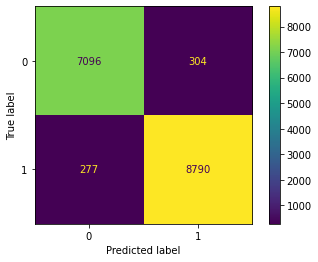

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      7400
           1       0.97      0.97      0.97      9067

    accuracy                           0.96     16467
   macro avg       0.96      0.96      0.96     16467
weighted avg       0.96      0.96      0.96     16467

Selected Features:  Index(['dbytes', 'rate', 'sttl', 'dttl', 'dload', 'sloss', 'dloss', 'sjit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'dmean', 'ct_srv_src', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_src_ltm',
       'ct_srv_dst'],
      dtype='object')


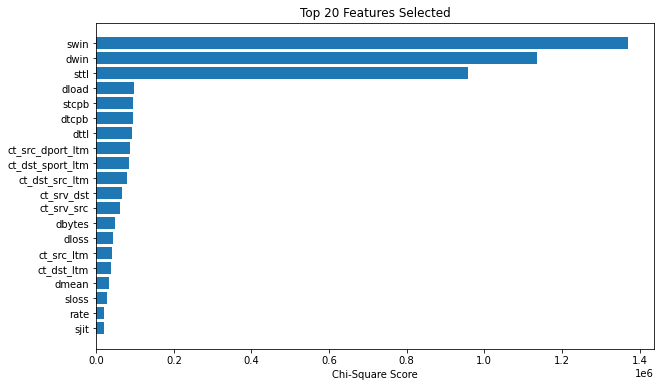

In [ ]:
# Feature Selection
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=0, stratify=y)

# Define pipeline
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=chi2, k=20)),  # Select top 20 features
    ('classifier', RandomForestClassifier(random_state=0))  # Classifier
])

# Train pipeline
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred))

# Display selected features
selected_features_mask = pipeline.named_steps['feature_selection'].get_support()
selected_features = X_encoded.columns[selected_features_mask]
print("Selected Features: ", selected_features)

# Plot feature importance
feature_scores = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Score': pipeline.named_steps['feature_selection'].scores_
}).sort_values(by='Score', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'][:20], feature_scores['Score'][:20])
plt.xlabel('Chi-Square Score')
plt.title('Top 20 Features Selected')
plt.gca().invert_yaxis()
plt.show()


In [667]:
X = X_encoded[selected_features]
X

,dbytes,rate,sttl,dttl,dload,sloss,dloss,sjit,swin,stcpb,dtcpb,dwin,dmean,ct_srv_src,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst
0,0.000000,11.417626,254,0,0.000000,0.0,0.0,0.000000,0,0.000000,0.000000,0,0.000000,2.0,1.0,1.0,1.0,2.0,1.0,2.0
1,0.000000,11.736077,254,0,0.000000,0.0,0.0,0.000000,0,0.000000,0.000000,0,0.000000,2.0,1.0,1.0,1.0,2.0,1.0,2.0
2,0.000000,12.206078,254,0,0.000000,0.0,0.0,0.000000,0,0.000000,0.000000,0,0.000000,3.0,1.0,1.0,1.0,3.0,1.0,3.0
3,0.000000,12.023757,254,0,0.000000,0.0,0.0,0.000000,0,0.000000,0.000000,0,0.000000,3.0,2.0,2.0,1.0,3.0,2.0,3.0
4,0.000000,11.512935,254,0,0.000000,0.0,0.0,0.000000,0,0.000000,0.000000,0,0.000000,3.0,2.0,2.0,1.0,3.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000000,12.206078,254,0,0.000000,0.0,0.0,0.000000,0,0.000000,0.000000,0,0.000000,1.0,2.0,1.0,1.0,2.0,2.0,1.0
82328,5.872118,3.235145,254,252,7.715619,7.0,1.0,8.476190,255,20.793291,21.912417,255,3.806662,1.0,2.0,1.0,1.0,1.0,3.0,2.0
82329,0.000000,0.000000,0,0,0.000000,0.0,0.0,0.000000,0,0.000000,0.000000,0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
82330,0.000000,0.000000,0,0,0.000000,0.0,0.0,2.481109,0,0.000000,0.000000,0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# **Modeling**

XGBoost - Train Accuracy: 97.32%
XGBoost - Test Accuracy: 96.14%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      7400
           1       0.96      0.97      0.97      9067

    accuracy                           0.96     16467
   macro avg       0.96      0.96      0.96     16467
weighted avg       0.96      0.96      0.96     16467



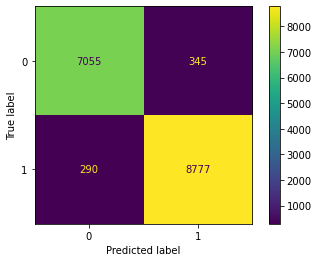

kNN - Train Accuracy: 97.34%
kNN - Test Accuracy: 95.12%

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      7400
           1       0.96      0.95      0.96      9067

    accuracy                           0.95     16467
   macro avg       0.95      0.95      0.95     16467
weighted avg       0.95      0.95      0.95     16467



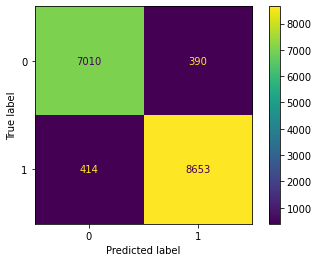

Random Forest - Train Accuracy: 99.61%
Random Forest - Test Accuracy: 96.47%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      7400
           1       0.97      0.97      0.97      9067

    accuracy                           0.96     16467
   macro avg       0.96      0.96      0.96     16467
weighted avg       0.96      0.96      0.96     16467



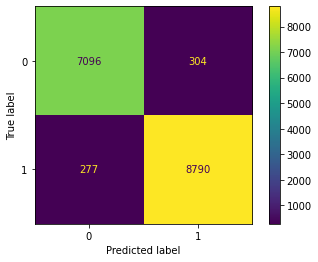

Logistic Regression - Train Accuracy: 83.92%
Logistic Regression - Test Accuracy: 84.24%

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      7400
           1       0.85      0.86      0.86      9067

    accuracy                           0.84     16467
   macro avg       0.84      0.84      0.84     16467
weighted avg       0.84      0.84      0.84     16467



C:\Users\rocks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


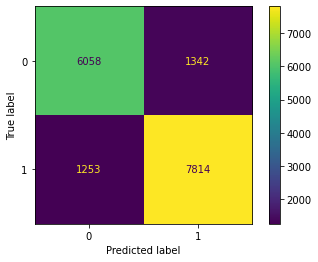

In [668]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Helper function to train and evaluate models
def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    print(f"{model_name} - Train Accuracy: {model.score(X_train, y_train) * 100:.2f}%")
    print(f"{model_name} - Test Accuracy: {model.score(X_test, y_test) * 100:.2f}%")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    plt.show()

# Train and evaluate models
evaluate_model(XGBClassifier(), "XGBoost")
evaluate_model(KNeighborsClassifier(n_neighbors=3), "kNN")
evaluate_model(RandomForestClassifier(random_state=0), "Random Forest")
evaluate_model(LogisticRegression(random_state=0, max_iter=1000), "Logistic Regression")